# DRO for colored MNIST

In [1]:
import os

import numpy as np
from PIL import Image
import random
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from torch.utils.data import DataLoader, random_split



## Prepare the colored MNIST dataset
We define three environments (two training, one test) by randomly splitting the MNIST dataset in thirds and transforming each example as follows:
1. Assign a binary label y to the image based on the digit: y = 0 for digits 0-4and y = 1 for digits 5-9.
2. Flip the label with 25% probability.
3. Color the image either red or green according to its (possibly flipped) label.
4. Flip the color with a probability e that depends on the environment: 20% inthe first training environment, 10% in the second training environment, and90% in the test environment.

In [2]:
def color_grayscale_arr(arr, red=True, nonRed='green'):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
    return arr
  elif nonRed=='green':
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  elif nonRed=='blue':
    arr = np.concatenate([np.zeros((h, w, 2),dtype=dtype),
                          arr], axis=2)
  else:
    arr=np.concatenate([arr,arr,arr], axis=2)
    
    for i in range(h):
        for j in range(w):
            if not arr[i,j,0]==0:
                col=np.random.uniform(0,253,3)
                arr[i,j,:]=col
                 
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    sampleSize (int between 1 and 60000): number of samples in this dataset
    startFrom (int between 0 and 60000-sampleSize): start index of sample
    flipLabel (float between 0 and 1): probability of flipping the label
    flipColor (float between 0 and 1): probability of flipping the color
    nonRed (string, one of 'green', 'blue', 'random'): nonRed color
    colorLabel (boolean): whether the dataset contains colorLabel
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, sampleSize=60000, startFrom=0, flipLabel=0.25, flipColor=0.2, nonRed='green', colorLabel=True, 
               root='./data', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)
    assert 1<=sampleSize<=60000 and 0<=flipLabel<=1 and 0<=flipColor<=1 and nonRed in ['green','blue','random']
    
    self.colorLabel = colorLabel
    
    self.prepare_colored_mnist(flipLabel,flipColor,sampleSize,startFrom,nonRed)

    self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 
                                   'FL{}FC{}SS{}CL{}.pt'.format(flipLabel, flipColor,sampleSize,nonRed)))


  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    
    img, target, color = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return (img, target, color) if self.colorLabel else (img, target)

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self,flipLabel,flipColor,sampleSize,startFrom,nonRed):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 
                                   'FL{}FC{}SS{}CL{}.pt'.format(flipLabel,flipColor,sampleSize,nonRed))): 
        #specific flipLabel, flipColor, SampleSize
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)
    
    data=[]
    sample=set(range(startFrom,startFrom+sampleSize))
    
    for idx, (im, label) in enumerate(train_mnist):
      #Only take first (sampleSize) images
      if idx not in sample:
            continue
      
      if idx % 10000 == 0:
        print(f'Converting image {idx-startFrom}/{sampleSize}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with (flipLabel) probability
      if np.random.uniform() < flipLabel:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability (flipColor) that depends on the environment
      if np.random.uniform() < flipColor:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, color_red, nonRed)

      data.append((Image.fromarray(colored_arr), binary_label, int(color_red)))
      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break
    
    if not os.path.exists(colored_mnist_dir):
      os.makedirs(colored_mnist_dir)
    torch.save(data, os.path.join(colored_mnist_dir, 'FL{}FC{}SS{}CL{}.pt'.format(flipLabel,flipColor,sampleSize,nonRed)))
    
    
    
    

In [3]:
def plot_dataset_digits(dataset): 
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []
  isColor = True if len(dataset[0]) == 3 else False  #isColor: whether the dataset contains colorLabel

  for i in range(columns * rows):
    if isColor:
        img, label, color = dataset[i]
    else:
        img, label = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot

## Name of the datasets:

**dataset**: Training set, flip 25% Color Label, sample size = 20000

**test**: flip 25% color label (same environment of training set), sample size = 5000

**test1**: flip 90% color label, sample size = 5000

**test2**: Colored nonRed group with random RGB value, flip 50% color label, sample size = 5000

As all the dataset flip 25% of digit label, theoretically, a "True" Model should obtain a 75% accuracy for every group.

### dataset: Training set, flip 20% of Color Label

In [4]:
dataset=ColoredMNIST(sampleSize=20000)

Preparing Colored MNIST
Converting image 0/20000
Converting image 10000/20000


In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=28x28>, 0, 1)

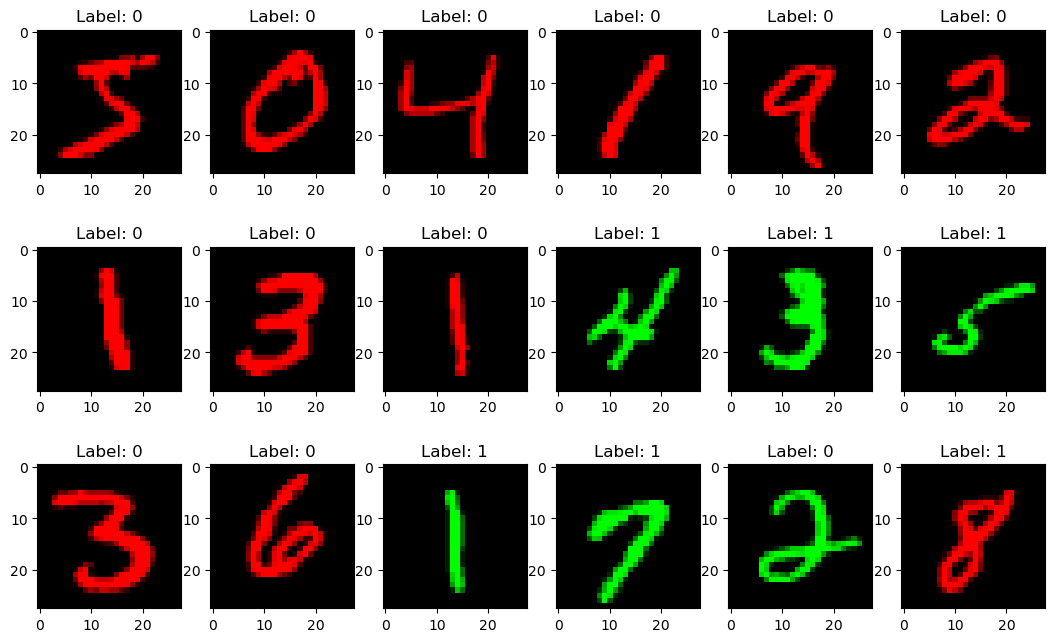

In [6]:
plot_dataset_digits(dataset)

In [7]:
dataset = ColoredMNIST(sampleSize=20000, root='./data',    
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))

Colored MNIST dataset already exists


In [8]:
#Devide dataset in groups
def datasetInGroups(dataset):
    groupName=['red1','red0','nonRed1','nonRed0']
    datasetG={gn:[] for gn in groupName}
    count = 0
    for img, tar, col in dataset:
        if tar==1 and col==1:
            datasetG['red1'].append((img,tar))
        elif tar==0 and col==1:
            datasetG['red0'].append((img,tar))
        elif tar==1 and col==0:
            datasetG['nonRed1'].append((img,tar))
        else:
            datasetG['nonRed0'].append((img,tar))
        count += 1
        if count%10000==0:
            print("Converting images {}".format(count))
        
    return datasetG

In [9]:
datasetG=datasetInGroups(dataset)
for d in datasetG:
    print(d,len(datasetG[d]))

Converting images 10000
Converting images 20000
red1 1978
red0 8112
nonRed1 7931
nonRed0 1979


In [10]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits

In [11]:
#DRO training
def train(datasetG,T,l2_lambd=.001, etaq=.001,etaT=.001,isModelList=True, storeModel = 200):
    '''
    Train function for DRO Model.
    
    Args:
      datasetG (dictionary): Training dataset splited in Groups, with observation and target
      T (positive integer): Total loops of training
      l2_lambd (positive float): l2-penality
      etaq (positive float): parameter controling the weight updating of groups
      etaT (positive float): parameter controling the learning rate
      isModelList (bool): Return a list of model if True, else return the model after training
      storeModel (positive integer): (Valid only if isModelList == True) number of training loops between 
                                     storing models in modelList
    '''
    model = ConvNet()
    optimizer = optim.Adam(model.parameters(), lr=etaT)
    modelList=[]
    groupName=['red1','red0','nonRed1','nonRed0']
    q = np.repeat(1/4,4)
    for t in range(T):
        optimizer.zero_grad()
        
        #Choose a random group
        groupIndex = random.sample(range(4),1)[0]
        group = groupName[groupIndex]
        
        #Sample one data point from the group
        img, tar = random.sample(datasetG[group],1)[0]
        
        output = model(img)
        
        #L2 regularization loss
        loss = F.binary_cross_entropy_with_logits(output,tar)
        l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        loss += l2_lambd * l2_norm
        
        #Update q
        lossNP = loss.detach().numpy()
        q[groupIndex] = q[groupIndex] * np.exp(etaq*lossNP)
        q /= q.sum()
        
        #Update theta
        for g in optimizer.param_groups:
            g['lr'] = etaT * q[groupIndex] #Change learning rate
        loss.backward()
        optimizer.step()

        
        if isModelList and (t+1)%storeModel==0:
            modelList.append(copy.deepcopy(model))
        if (t+1)%20000 == 0:
            print('Processing {}/{} loops'.format(t+1,T))
        
    
    return modelList if isModelList else model
        
        
        
        

## DRO With regularization

In [12]:
modelList=train(datasetG,260000, storeModel=2500)

Processing 20000/260000 loops
Processing 40000/260000 loops
Processing 60000/260000 loops
Processing 80000/260000 loops
Processing 100000/260000 loops
Processing 120000/260000 loops
Processing 140000/260000 loops
Processing 160000/260000 loops
Processing 180000/260000 loops
Processing 200000/260000 loops
Processing 220000/260000 loops
Processing 240000/260000 loops
Processing 260000/260000 loops


In [13]:
modelList[0:5]

[ConvNet(
   (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=1, bias=True)
 ),
 ConvNet(
   (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=1, bias=True)
 ),
 ConvNet(
   (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=1, bias=True)
 ),
 ConvNet(
   (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_f

In [14]:
len(modelList)

104

In [15]:
#Compute the accuracy by Groups of a model with given dataset
def accuracy(model,datasetG,accDic):
    for gn, d in datasetG.items():
        a=0
        for img, tar in d:
            pred = torch.where(torch.gt(model(img), torch.Tensor([0.0])),
                         torch.Tensor([1.0]),
                         torch.Tensor([0.0]))
            a+=1 if pred == tar else 0
        accDic[gn].append(a/len(d))
    return accDic

#Compute the accuracy by Groups of a modelList
def ModelListAccuracy(modelList, datasetG):
    groupName=['red1','red0','nonRed1','nonRed0']
    accDic={gn:[] for gn in groupName}
    for idx, model in enumerate(modelList):
        accDic = accuracy(model,datasetG,accDic)
        print('Processing model {} / {}'.format(idx+1,len(modelList)))  if (idx+1)%10 == 0 else None
    return accDic
            

In [16]:
#Training Accuracy
TrainAcc = ModelListAccuracy(modelList, datasetG)  

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

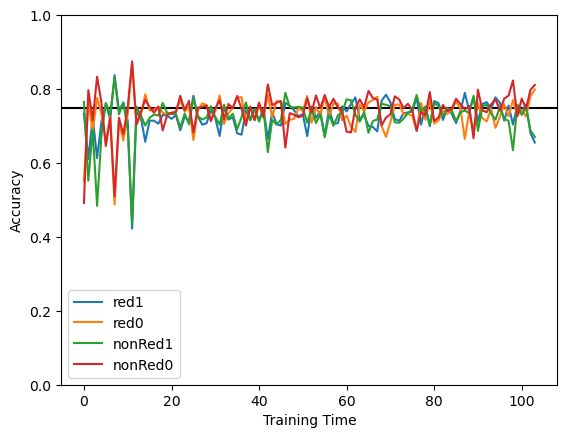

In [57]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(TrainAcc['red1'],label='red1')
plt.plot(TrainAcc['red0'],label='red0')
plt.plot(TrainAcc['nonRed1'],label='nonRed1')
plt.plot(TrainAcc['nonRed0'],label='nonRed0')

plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

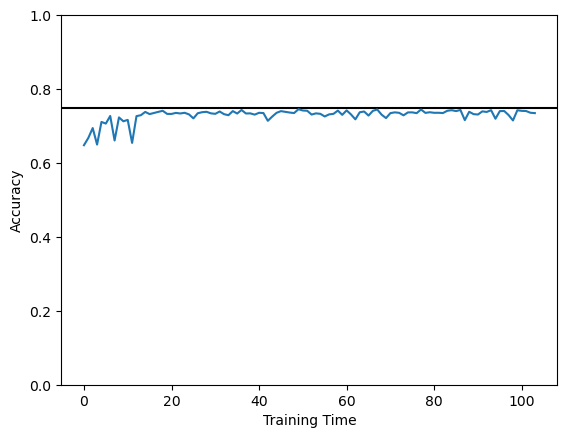

In [58]:
#Compute the average accuracy
def averageAccuracy(groupedAccuracy,datasetG):
    groupName=['red1','red0','nonRed1','nonRed0']
    AvgAcc = np.repeat(0,len(groupedAccuracy['red1']))
    total = 0
    for gn in groupName:
        AvgAcc = AvgAcc + np.array(groupedAccuracy[gn])*len(datasetG[gn])
        total += len(datasetG[gn])
    AvgAcc /= total
    return AvgAcc

plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(TrainAcc,datasetG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [19]:
#Combine the Grouped accuracy, Worst group accuracy, and average accuracy of a specific model in the modelList
#(Last model by default).
def FinalAccuracy(groupedAccuracy,datasetG,modelIndex=-1):
    groupName= ['red1', 'red0', 'nonRed1', 'nonRed0']
    final={}
    for gn in groupName:
        final[gn] = groupedAccuracy[gn][modelIndex]
    final['WorstAcc'] = min(final.values())
    final['AvgAcc'] = averageAccuracy(groupedAccuracy, datasetG)[modelIndex]
    return final

FinalAccuracy(TrainAcc,datasetG)

{'red1': 0.6552072800808898,
 'red0': 0.798939842209073,
 'nonRed1': 0.6701550876308158,
 'nonRed0': 0.8110156644770086,
 'WorstAcc': 0.6552072800808898,
 'AvgAcc': 0.73485}

### test set: Comes from same environment of Training set

Preparing Colored MNIST
Converting image 0/5000


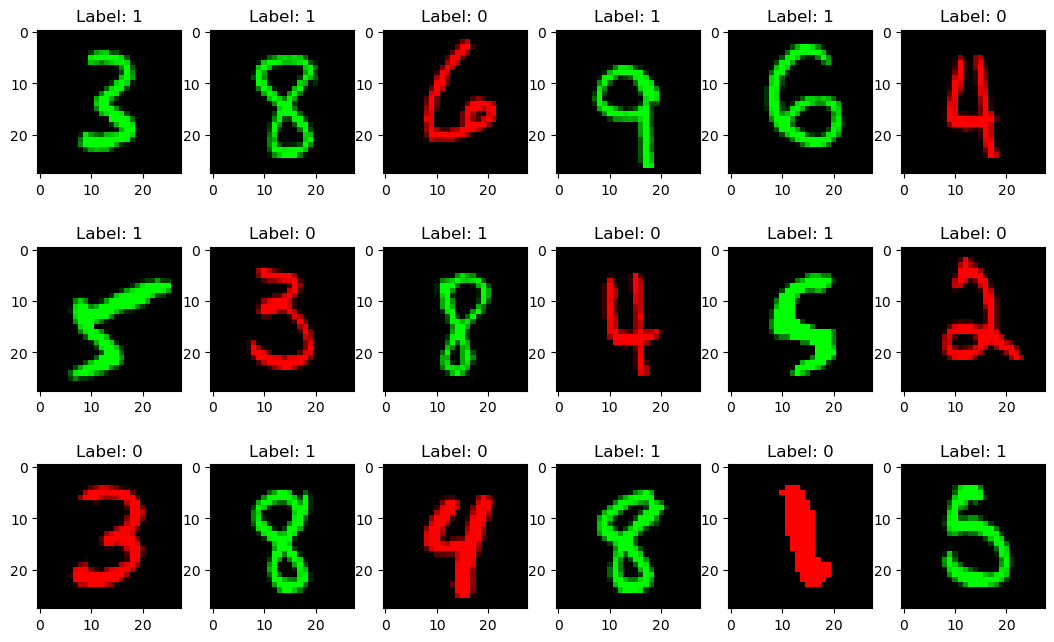

In [20]:
test=ColoredMNIST(sampleSize=5000,startFrom=50000)
plot_dataset_digits(test)

In [21]:
test = ColoredMNIST(sampleSize=5000, startFrom=50000,  
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))
testG=datasetInGroups(test)
for d in testG:
    print(d,len(testG[d]))

Colored MNIST dataset already exists
red1 506
red0 2037
nonRed1 1956
nonRed0 501


In [22]:
testAcc = ModelListAccuracy(modelList, testG)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

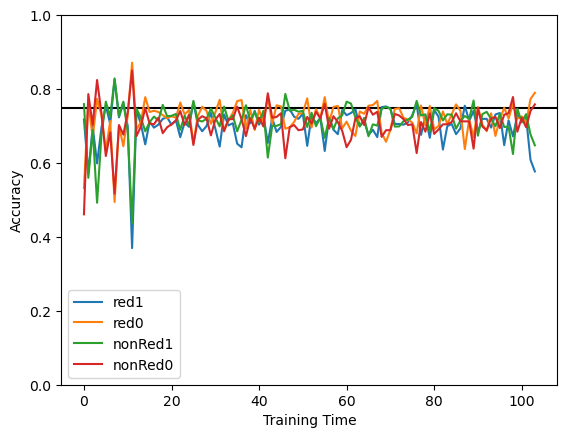

In [59]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(testAcc['red1'],label='red1')
plt.plot(testAcc['red0'],label='red0')
plt.plot(testAcc['nonRed1'],label='nonRed1')
plt.plot(testAcc['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

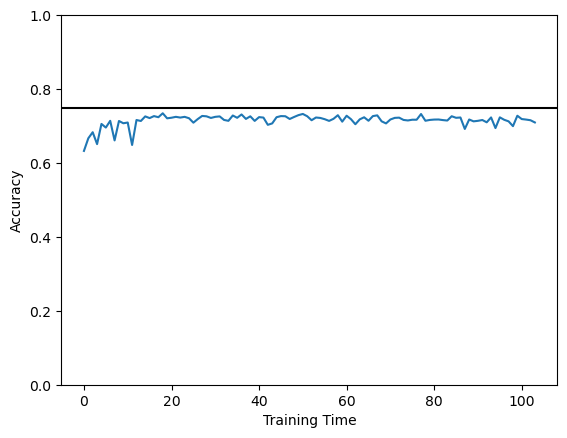

In [60]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(testAcc,testG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [25]:
FinalAccuracy(testAcc,testG)

{'red1': 0.5770750988142292,
 'red0': 0.789887088856161,
 'nonRed1': 0.6477505112474438,
 'nonRed0': 0.7584830339321357,
 'WorstAcc': 0.5770750988142292,
 'AvgAcc': 0.7096}

### test1 set: Flip 90% of color label

Preparing Colored MNIST
Converting image 0/5000


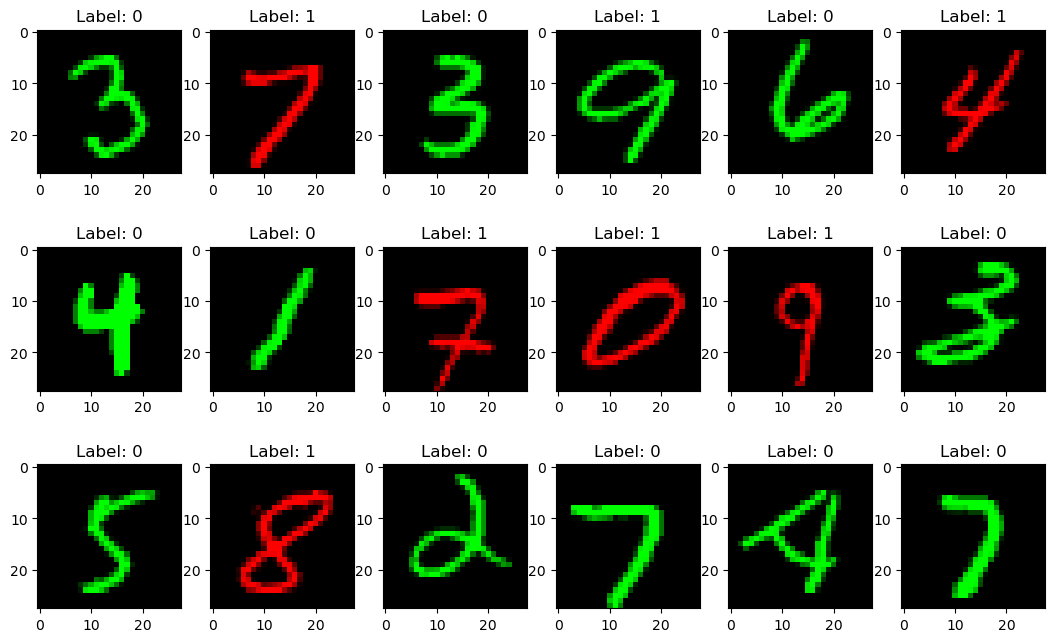

In [26]:
test1=ColoredMNIST(sampleSize=5000,startFrom=30000,flipColor=.9)
plot_dataset_digits(test1)

In [27]:
test1 = ColoredMNIST(sampleSize=5000,flipColor=.9, startFrom=30000,  
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))
test1G=datasetInGroups(test1)
for d in test1G:
    print(d,len(test1G[d]))

Colored MNIST dataset already exists
red1 2266
red0 257
nonRed1 237
nonRed0 2240


In [28]:
test1Acc = ModelListAccuracy(modelList, test1G)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

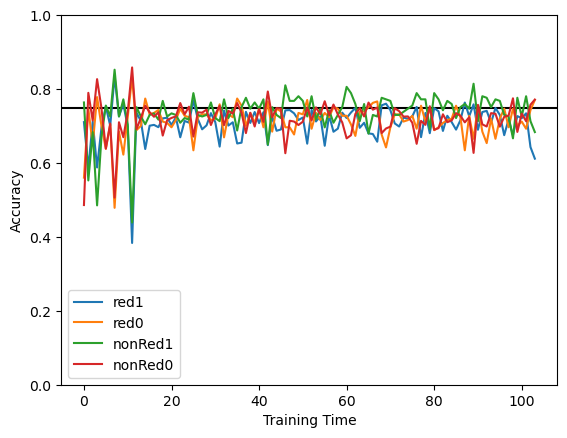

In [61]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(test1Acc['red1'],label='red1')
plt.plot(test1Acc['red0'],label='red0')
plt.plot(test1Acc['nonRed1'],label='nonRed1')
plt.plot(test1Acc['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

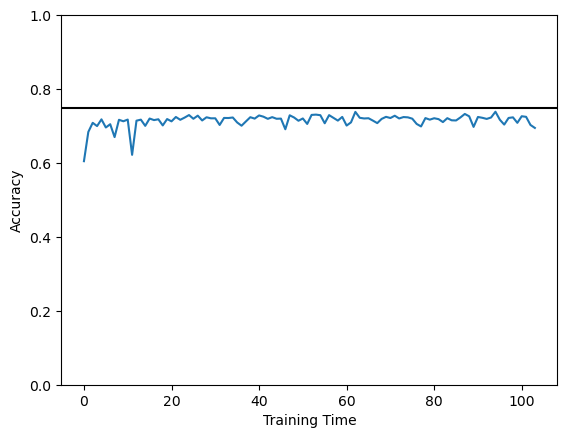

In [62]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(test1Acc,test1G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [31]:
FinalAccuracy(test1Acc,test1G)

{'red1': 0.6116504854368932,
 'red0': 0.7704280155642024,
 'nonRed1': 0.6835443037974683,
 'nonRed0': 0.7714285714285715,
 'WorstAcc': 0.6116504854368932,
 'AvgAcc': 0.6948}

### test2 set: Colored the nonRed groups with arbitrary RGB values, Flip 50% of Color

Preparing Colored MNIST
Converting image 0/5000


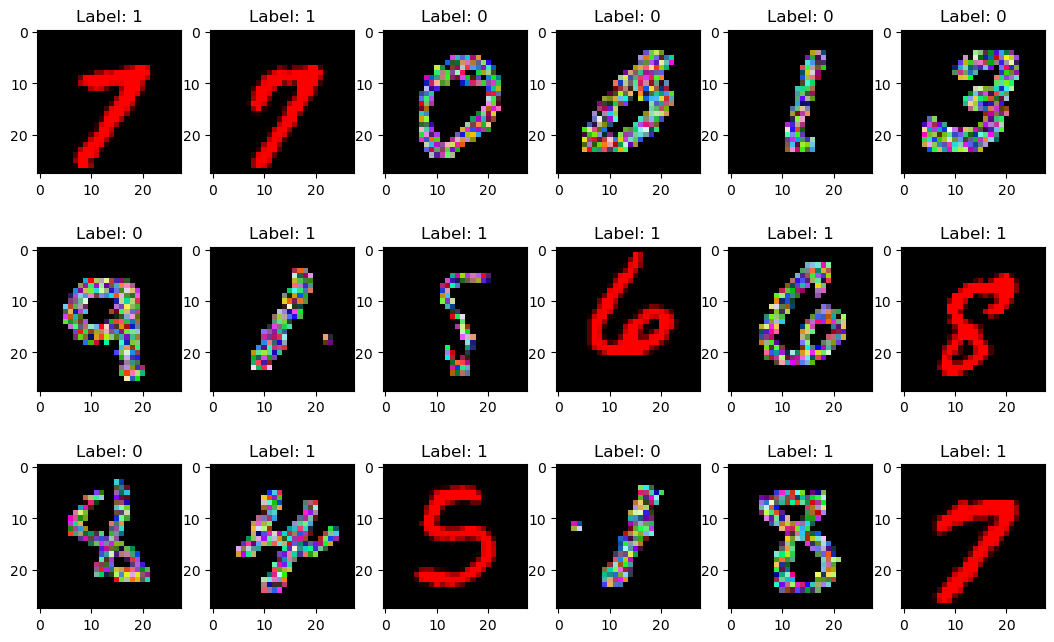

In [32]:
test2=ColoredMNIST(sampleSize=5000,startFrom=40000,flipColor=.5, nonRed='random')
plot_dataset_digits(test2)   

In [33]:
test2=ColoredMNIST(sampleSize=5000,flipColor=.5, nonRed='random', startFrom=40000,
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))
test2G=datasetInGroups(test2)
for d in test2G:
    print(d,len(test2G[d]))

Colored MNIST dataset already exists
red1 1257
red0 1278
nonRed1 1255
nonRed0 1210


In [34]:
test2Acc = ModelListAccuracy(modelList, test2G)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

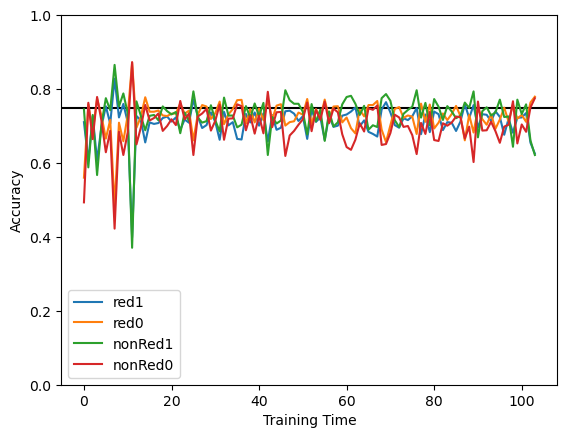

In [63]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(test2Acc['red1'],label='red1')
plt.plot(test2Acc['red0'],label='red0')
plt.plot(test2Acc['nonRed1'],label='nonRed1')
plt.plot(test2Acc['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

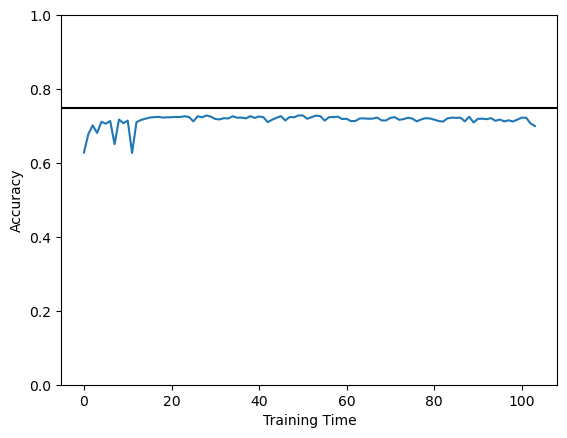

In [64]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(test2Acc,test2G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [37]:
FinalAccuracy(test2Acc,test2G)

{'red1': 0.6252983293556086,
 'red0': 0.7793427230046949,
 'nonRed1': 0.6215139442231076,
 'nonRed0': 0.775206611570248,
 'WorstAcc': 0.6215139442231076,
 'AvgAcc': 0.7}

## DRO Without regularization

In [38]:
modelList2=train(datasetG,260000, storeModel=2500, l2_lambd=0)

Processing 20000/260000 loops
Processing 40000/260000 loops
Processing 60000/260000 loops
Processing 80000/260000 loops
Processing 100000/260000 loops
Processing 120000/260000 loops
Processing 140000/260000 loops
Processing 160000/260000 loops
Processing 180000/260000 loops
Processing 200000/260000 loops
Processing 220000/260000 loops
Processing 240000/260000 loops
Processing 260000/260000 loops


### Accuracy for dataset (Training set, flip 20% of Color Label)

In [39]:
TrainAcc2 = ModelListAccuracy(modelList2, datasetG)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

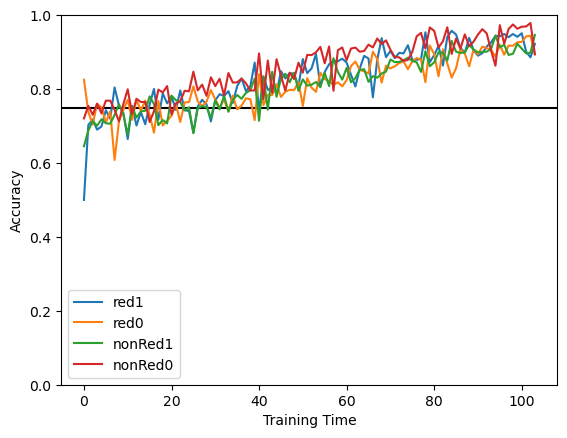

In [65]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(TrainAcc2['red1'],label='red1')
plt.plot(TrainAcc2['red0'],label='red0')
plt.plot(TrainAcc2['nonRed1'],label='nonRed1')
plt.plot(TrainAcc2['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

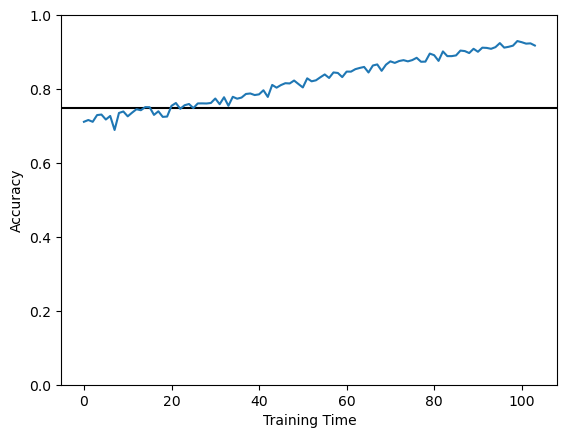

In [66]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(TrainAcc2,datasetG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [42]:
FinalAccuracy(TrainAcc2,datasetG)

{'red1': 0.9221435793731041,
 'red0': 0.8943540433925049,
 'nonRed1': 0.9464128104904804,
 'nonRed0': 0.8938858009095503,
 'WorstAcc': 0.8938858009095503,
 'AvgAcc': 0.9177}

### Accuracy for test set (flip 20% of Color Label)

In [43]:
testAcc2 = ModelListAccuracy(modelList2, testG)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

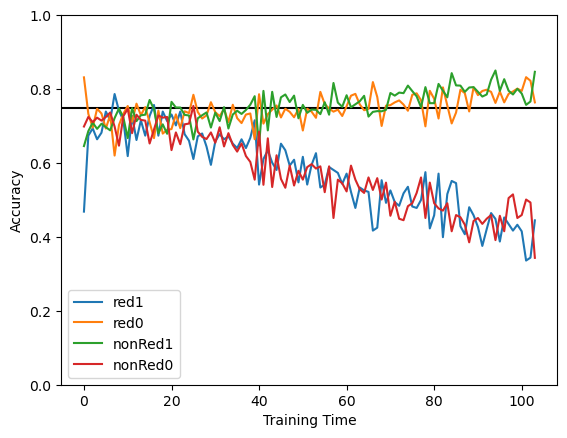

In [67]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(testAcc2['red1'],label='red1')
plt.plot(testAcc2['red0'],label='red0')
plt.plot(testAcc2['nonRed1'],label='nonRed1')
plt.plot(testAcc2['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

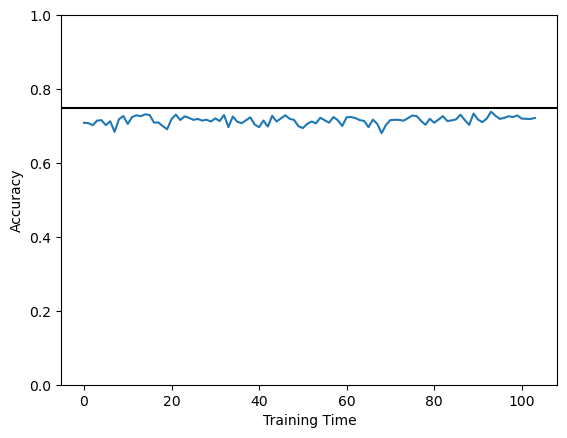

In [68]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(testAcc2,testG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [46]:
FinalAccuracy(testAcc2,testG)

{'red1': 0.44466403162055335,
 'red0': 0.7638684339715267,
 'nonRed1': 0.8466257668711656,
 'nonRed0': 0.34331337325349304,
 'WorstAcc': 0.34331337325349304,
 'AvgAcc': 0.7218}

### Accuracy for test1 set (flip 90% of Color Label)

In [47]:
test1Acc2 = ModelListAccuracy(modelList2, test1G)


Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

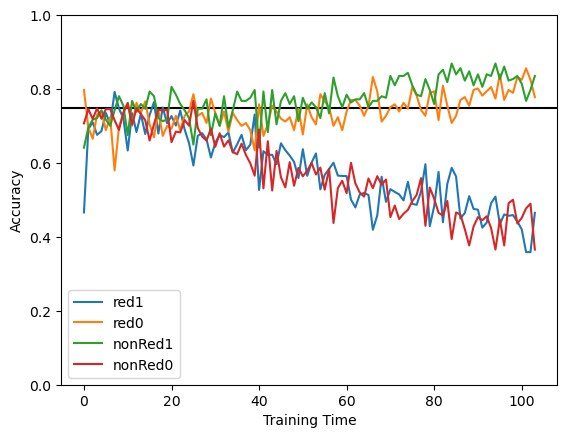

In [69]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(test1Acc2['red1'],label='red1')
plt.plot(test1Acc2['red0'],label='red0')
plt.plot(test1Acc2['nonRed1'],label='nonRed1')
plt.plot(test1Acc2['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

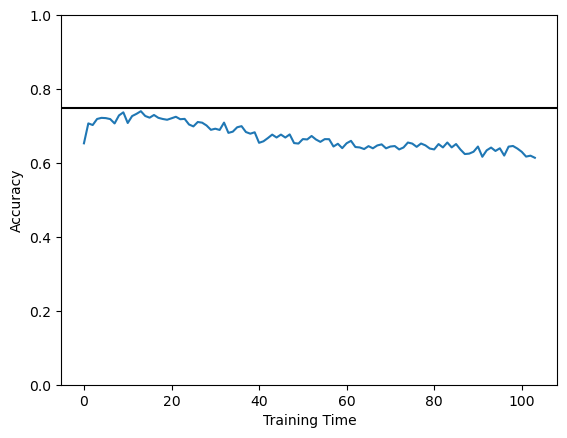

In [70]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(test1Acc2,test2G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [50]:
FinalAccuracy(test1Acc2,test1G)

{'red1': 0.4651368049426302,
 'red0': 0.7782101167315175,
 'nonRed1': 0.8354430379746836,
 'nonRed0': 0.365625,
 'WorstAcc': 0.365625,
 'AvgAcc': 0.4542}

### Accuracy for test2 set (color the nonRed groups with arbitrary RGB values, flip 50% of Color Label)

In [51]:
test2Acc2 = ModelListAccuracy(modelList2, test2G)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


Text(0, 0.5, 'Accuracy')

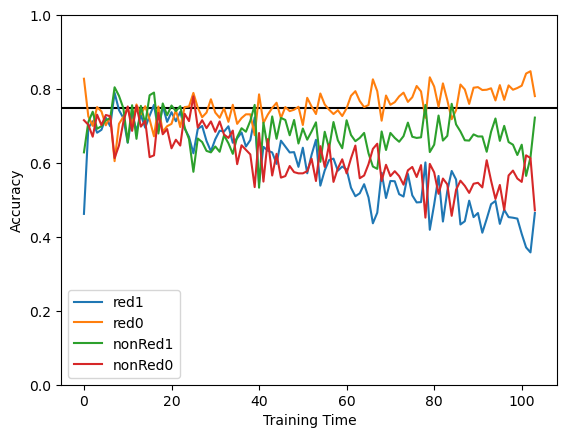

In [71]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(test2Acc2['red1'],label='red1')
plt.plot(test2Acc2['red0'],label='red0')
plt.plot(test2Acc2['nonRed1'],label='nonRed1')
plt.plot(test2Acc2['nonRed0'],label='nonRed0')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

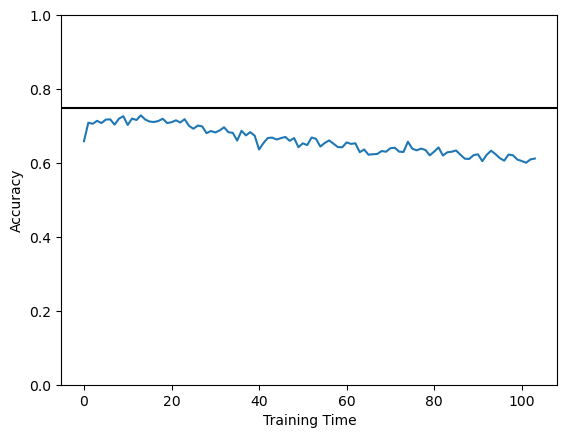

In [72]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(averageAccuracy(test2Acc2,test2G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [54]:
FinalAccuracy(test2Acc2,test2G)

{'red1': 0.46459824980111375,
 'red0': 0.7809076682316118,
 'nonRed1': 0.7227091633466135,
 'nonRed0': 0.471900826446281,
 'WorstAcc': 0.46459824980111375,
 'AvgAcc': 0.612}

## Plots combining the training and testing accuracy by groups

Text(0.5, 1.0, 'DRO with regularization')

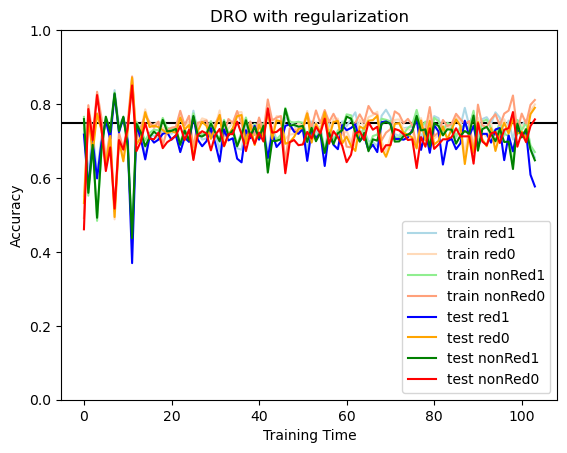

In [73]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(TrainAcc['red1'],label='train red1',color='lightblue')
plt.plot(TrainAcc['red0'],label='train red0',color='peachpuff')
plt.plot(TrainAcc['nonRed1'],label='train nonRed1',color='lightgreen')
plt.plot(TrainAcc['nonRed0'],label='train nonRed0',color='lightsalmon')
plt.plot(testAcc['red1'],label='test red1',color='blue')
plt.plot(testAcc['red0'],label='test red0',color='orange')
plt.plot(testAcc['nonRed1'],label='test nonRed1',color='green')
plt.plot(testAcc['nonRed0'],label='test nonRed0',color='red')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.title('DRO with regularization')

Text(0.5, 1.0, 'DRO without regularization')

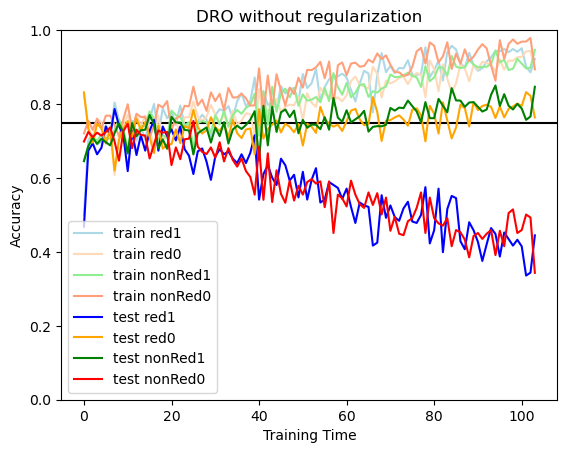

In [74]:
plt.axhline(y=0.75,color='black',linestyle='-')
plt.plot(TrainAcc2['red1'],label='train red1',color='lightblue')
plt.plot(TrainAcc2['red0'],label='train red0',color='peachpuff')
plt.plot(TrainAcc2['nonRed1'],label='train nonRed1',color='lightgreen')
plt.plot(TrainAcc2['nonRed0'],label='train nonRed0',color='lightsalmon')
plt.plot(testAcc2['red1'],label='test red1',color='blue')
plt.plot(testAcc2['red0'],label='test red0',color='orange')
plt.plot(testAcc2['nonRed1'],label='test nonRed1',color='green')
plt.plot(testAcc2['nonRed0'],label='test nonRed0',color='red')
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.title('DRO without regularization')